# [Cardiovascular Disease](https://www.kaggle.com/datasets/sulianova/cardiovascular-disease-dataset) Part 2 – FE

---

**Заказчик**

Для внутреннего (Яндекс.Практикум) соревнования [Heart diseases prediction](https://www.kaggle.com/competitions/yap15-heart-diseases-predictions).

---

**Входные данные**: параметры обследованных пациентов; данные изначально разделены на обучающий и тестовый наборы.

---

**Цель**

Predict risk of heart diseases from patient lifestyle information.  
Целевая метрика – ROC-AUC-score.

---

**Задачи:**  

* Установить характеристики пациентов наиболее часто страдающих ССЗ
* Установить характеристики пациентов входящих в группу риска ССЗ
* Подобрать оптимальную модель соответствующую качеству 

**Some explanations**

---

Permanent data tables named like: **data**.  

Temporary data tables named like: **df**.  

---

Intermediate conclusions are highlighted as follows:

> Intermediate conclusion.

---

The code of the cells are as independent as possible from each other in order to freely manipulate the cells.

## Intro

Features:

|                      Feature Full Name       |  Feature origin   | Feature Name |                    Data Type (units)       |
|:---------------------------------------------|:-------------------|:-----------|:--------------------------------------------|
|                      Age                      |  Objective Feature  |     age     |                    int (days)                    |
| Height                                        | Objective Feature   | height      | int (cm)                                         |
| Weight                                        | Objective Feature   | weight      | float (kg)                                       |
| Gender                                        | Objective Feature   | gender      | categorical code                                 |
| Systolic blood pressure                       | Examination Feature | ap_hi       | int                                              |
| Diastolic blood pressure                      | Examination Feature | ap_lo       | int                                              |
| Cholesterol                                   | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
| Glucose                                       | Examination Feature | gluc        | 1: normal, 2: above normal, 3: well above normal |
| Smoking                                       | Subjective Feature  | smoke       | binary                                           |
| Alcohol intake                                | Subjective Feature  | alco        | binary                                           |
| Physical activity                             | Subjective Feature  | active      | binary                                           |
| Presence or absence of cardiovascular disease | Target Variable     | cardio      | binary                                           |

All of the dataset values were collected at the moment of medical examination. 

## Initial

**Import libraries | Импортировать библиотеки**

In [1]:
import pandas as pd
import numpy as np

import os
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import plotly.graph_objects as go
import plotly.io as pio

import phik
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.decomposition import PCA

### Constants | Константа

In [2]:
# PATH_LOCAL = 'datasets/'                                              # local path to data
# PATH_REMOTE = '/kaggle/input/yap15-heart-diseases-predictions/'       # remote path to data

CR = '\n'                                                             # new line
RANDOM_STATE = RS = 88                                                # random_state

### Functions | Функции

In [4]:
# def custom_read_csv(file_name, separator=','):
#     """
#     чтение датасета в формате CSV:
#       сначала из локального хранилища;
#       при неудаче — из удаленного хранилища Kaggle.
#     """

#     path_local = f'{PATH_LOCAL}{file_name}'
#     path_remote = f'{PATH_REMOTE}{file_name}'
    
#     if os.path.exists(path_local):
#         return pd.read_csv(path_local, sep=separator)

#     elif os.path.exists(path_remote):
#         return pd.read_csv(path_remote, sep=separator)

#     else:
#         print(f'File "{file_name}" not found at the specified path ')

In [5]:
def df_name(df):
    """
    table name determination
    """
    return [name for name in globals() if globals()[name] is df][0]

In [6]:
def basic_info(df: pd.DataFrame, sample_type='sample', samples=5, describe='all'):
    """
    first info about dataframe: info(), sample()/head()/tail(), describe()
    """
    
    # title (name of dataframe)
    
    print(f'\n\ndataframe {f.BOLD}{df_name(df)}{f.END}', '≋'*30)


    # method info()
    
    print('\n\n--- method info() ---\n')
    print(df.info())

    
    # several random records
    
    print(f'\n\n--- method {sample_type}({samples}) ---')
    
    if sample_type == 'sample':
        display(df.sample(samples))
    elif sample_type == 'head':
        display(df.head(samples))
    elif sample_type == 'tail':
        display(df.tail(samples))
    else:
        print(f'{sample_type} – invalid value for parameter "sample_type" ')
    
    
    # method describe()
    
    print(f'\n\n--- method describe({describe}) ---')
    
    if describe=='all' or describe=='numeric':
        try:
            display(df.describe(include=np.number))
        except ValueError:
            pass

    if describe=='all' or describe=='categorical':
        try:
            display(df.describe(exclude=np.number).T)
        except ValueError:
            pass
    
    if describe not in ['numeric','categorical','all']:
        print(f'{describe} – invalid value for parameter "describe" ')

In [7]:
def apply_PCA(X_train, X_test, prefix='', standardize=True):
    
    # Standardize
    if standardize:
        X_train = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0)
    
    # Create principal components
    pca = PCA()
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    # Convert to dataframe
    component_names = [f'{prefix}PC{i+1}' for i in range(X_train_pca.shape[1])]
    X_train_pca = pd.DataFrame(X_train_pca, columns=component_names)
    X_test_pca = pd.DataFrame(X_test_pca, columns=component_names)
    
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,        # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X_train.columns,    # and the rows are the original features
    )
    
    return X_train_pca, X_test_pca, loadings, component_names

In [8]:
def mutual_info(X: pd.DataFrame, Y: pd.DataFrame, task=None, min_neighbors=1, max_neighbors=7):
    
    if max_neighbors < min_neighbors:
        print("Parameter 'max_neighbors' can't be less then parameter 'min_neighbors'.")
        return
    
    df_mutual_info = pd.DataFrame(index=X.columns)
    
    # Label encoding for categoricals
    for column in X.select_dtypes(exclude='number'):
        X[column], _ = X[column].factorize()

    # All discrete features should have integer dtypes
#     discrete_features_lst = (X.dtypes == int)             # маска (булевый вектор) выделяющий дискретные признаки
#     df_mutual_info[f'k_{k_neighbors}'] = mutual_info_classif(X, Y, n_neighbors=n, discrete_features=discrete_features_lst, random_state=RS)

    for k in range(min_neighbors, max_neighbors+1, 2):
        if task=='classification':
            df_mutual_info[f'k_{k}'] = mutual_info_classif(X, Y, n_neighbors=k, random_state=RS)
        elif task=='regression':
            df_mutual_info[f'k_{k}'] = mutual_info_regression(X, Y, n_neighbors=k, random_state=RS)
        else:
            print('Wrong parameter "task". Available task="classification" or task="regression".')
            return
    
    df_mutual_info['average'] = df_mutual_info.mean(axis=1)
    df_mutual_info = df_mutual_info.sort_values('average', ascending=False)
    
    display(df_mutual_info)
    
    fig, ax = plt.subplots(figsize=(15, df_mutual_info.shape[0]/3), dpi=PLOT_DPI)
    sns.barplot(x=df_mutual_info.average, y=df_mutual_info.index, color='steelblue')
    ax.set_xlabel(f'mutual_info (average across from 1 to {max_neighbors} neighbours)');

### Settings | Установки

In [9]:
# text styles
class f:
    BOLD = "\033[1m"
    ITALIC = "\033[3m"
    END = "\033[0m"

In [10]:
# defaults for charts

# Matplotlib, Seaborn
PLOT_DPI = 150  # dpi for charts rendering 
sns.set_style('whitegrid', {'axes.facecolor': '0.98', 'grid.color': '0.9', 'axes.edgecolor': '1.0'})
plt.rc(
       'axes',
       labelweight='bold',
       titlesize=14,
       titlepad=10,
      )

# Plotly Graph_Objects
pio.templates['my_theme'] = go.layout.Template(
                                               layout_autosize=True,
                                               # width=900,
                                               layout_height=200,
                                               layout_legend_orientation="h",
                                               layout_margin=dict(t=40, b=40),         # (l=0, r=0, b=0, t=0, pad=0)
                                               layout_template='seaborn',
                                              )
pio.templates.default = 'my_theme'

# colors, color schemes
CMAP_SYMMETRIC = LinearSegmentedColormap.from_list('', ['steelblue', 'aliceblue', 'steelblue'])

In [11]:
# Pandas defaults
pd.options.display.max_colwidth = 100
pd.options.display.max_rows = 500
pd.options.display.max_columns = 100
pd.options.display.float_format = '{:.3f}'.format
pd.options.display.colheader_justify = 'left'

In [12]:
# others
warnings.filterwarnings('ignore')

### Download datasets | Загрузка данных

In [25]:
data_train = pd.read_csv("C:\\Users\\Admin\\Desktop\\DS studies\\Data\\Heart diseases\\PROJECT\\FINAL\\EDA_train.csv")
data_test = pd.read_csv("C:\\Users\\Admin\\Desktop\\DS studies\\Data\\Heart diseases\\PROJECT\\FINAL\\EDA_test.csv")

In [26]:
#data_train = data_train.drop('id',axis = 1)
#data_test = data_test.drop('id',axis = 1)

Перемещение целевого признака `cardio` в начало датафрейма.

In [27]:
data_train = pd.concat([data_train[['cardio']], data_train.drop('cardio', axis=1)], axis=1)

In [28]:
data_train.head(3)

,cardio,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,bmi
0,0,0,50,0,168,62,110,80,1,1,0,0,1,21.967
1,1,1,55,1,156,85,140,90,3,1,0,0,1,34.928
2,1,2,52,1,165,64,130,70,3,1,0,0,0,23.508


In [29]:
data_test.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,bmi
0,5,52,1,154,85,130,80,1,1,0,0,1,35.841
1,6,52,0,170,69,130,90,1,1,0,0,1,23.875
2,7,56,1,160,70,120,80,1,1,0,0,0,27.344


## **New features**

In [30]:
def target_encode(df_train, df_test, feature_list, target, agg_func_list=['mean'], fill_na=0.5):
    '''
    Принимает feature_list и делает для него target encoding,
    используя заданную функцию аггрегации agg_func.
    Если возникают
    '''
    
    for agg_func in agg_func_list:
    
        new_feature = '_'.join(feature_list) + '_TRG_' + agg_func

        df_train[new_feature] = df_train.groupby(feature_list)[target].transform(agg_func)
        df_train[new_feature] = df_train[new_feature].fillna(fill_na)

        df_test = df_test.merge(
                                df_train[feature_list + [new_feature]].drop_duplicates(),
                                on=feature_list,
                                how="left",
                               )
        df_test[new_feature] = df_test[new_feature].fillna(fill_na)

        new_num_features_list.append(new_feature)
    
    return df_train, df_test

**Списки для удобства отслеживания новых признаков**

In [31]:
new_num_features_list = []
new_cat_features_list = []

Дискреизация интервальных признаков

Оригинальный **age** имеет странные регулярные провалы – где малое количество пациентов определенного возраста. Из-за этого в местах провалов возникает риск переобучения. Дискретизация сглаживает этот деффект.

In [32]:
for df in [data_train, data_test]:
    df['weight_bined'] = pd.cut(df.weight, bins=np.linspace(0, 200, 51), labels=False)
    df['height_bined'] = pd.cut(df.height, bins=np.linspace(0, 200, 51), labels=False)
    df['age_bined'] = pd.cut(df.age, bins=np.linspace(0, 100, 51), labels=False)
    df['aphi_bined'] = pd.cut(df.ap_hi, bins=np.linspace(0, 250, 26), labels=False)
    df['aplo_bined'] = pd.cut(df.ap_lo, bins=np.linspace(0, 150, 16), labels=False)
    df['bmi_bined'] = pd.cut(df.bmi, bins=np.linspace(0, 150, 16), labels=False)

In [33]:
#data_train[['age','age_bined']].sample(10)

**Сalculated features**

In [34]:
# for df in [data_train, data_test]:
    
#     df['age_weight_prod'] = df.age * df.weight
#     df['ap_prod'] = df.ap_hi * df.ap_lo
    
#     df['weight_height_ratio'] = df.weight / df.height
#     df['squared_weight_to_height'] = df.weight**2 / df.height
#     df['weight_to_squared_height'] = df.weight / df.height**2

#     df['aphi_aplo_ratio'] = df.ap_hi / df.ap_lo
#     df['aphi_aplo_difference'] = df.ap_hi - df.ap_lo
#     df['ap_hi_125'] = np.select([df.ap_hi <= 125, df.ap_hi > 125], [0, 1])
#     df['ap_lo_79_84'] = np.select([df.ap_lo < 79, df.ap_lo < 85, df.ap_lo >= 85], ['low','eql','high'])
    
#     df['sum_risk_factor'] = df.cholesterol*134 + df.gluc*55 + df.smoke*24 + df.alco*10 - df.active*56

# new_num_features_list.append('age_weight_prod')
# new_num_features_list.append('ap_prod')

**Target Encoding: gender, aphi_bined, aplo_bined**

С дискретизацией и без нее результаты близки. Оставил с бинизацией на всякий случай.

In [35]:
data_train, data_test = target_encode(data_train, data_test,
                                      feature_list=['gender','aphi_bined','aplo_bined'],
                                      target='cardio', agg_func_list=['mean'], fill_na=0.5)

**Target Encoding: gender, age, bmi_bined**

In [36]:
data_train, data_test = target_encode(data_train, data_test,
                                      feature_list=['gender','age','bmi_bined'],
                                      target='cardio', agg_func_list=['mean'], fill_na=0.5)

**Target Encoding: gender, age**

Без дискретизации происходит overfit из-за того, что распределение возраста имеет странные разрежения.

In [37]:
data_train, data_test = target_encode(data_train, data_test,
                                      feature_list=['gender','age'],
                                      target='cardio', agg_func_list=['mean'], fill_na=0.5)

**Target Encoding: gender, weight_bined, height_bined**

In [38]:
data_train, data_test = target_encode(data_train, data_test,
                                      feature_list=['gender','weight_bined','height_bined'],
                                      target='cardio', agg_func_list=['mean'], fill_na=0.5)

**Target Encoding: gender, cholesterol, gluc**

In [39]:
data_train, data_test = target_encode(data_train, data_test,
                                      feature_list=['gender','cholesterol','gluc'],
                                      target='cardio', agg_func_list=['mean'], fill_na=0.5)

In [40]:
data_train.groupby(['gender','cholesterol','gluc']).cardio.mean().unstack()

gluc                1     2     3   
gender cholesterol                  
0      1           0.441 0.556 0.421
       2           0.636 0.633 0.562
       3           0.798 0.813 0.680
1      1           0.425 0.523 0.482
       2           0.580 0.572 0.617
       3           0.830 0.812 0.692

**Target Encoding: gender, active**

In [41]:
data_train, data_test = target_encode(data_train, data_test,
                                      feature_list=['gender','active'],
                                      target='cardio', agg_func_list=['mean'], fill_na=0.5)

In [42]:
data_train.groupby(['gender','active']).cardio.mean().unstack()

active,0,1
gender,,
0,0.551,0.488
1,0.523,0.484


**Target Encoding: gender, smoke, alco**

In [43]:
data_train, data_test = target_encode(data_train, data_test,
                                      feature_list=['gender','smoke'],
                                      target='cardio', agg_func_list=['mean'], fill_na=0.5)

In [44]:
data_train.groupby(['gender','smoke']).cardio.mean().unstack()

smoke,0,1
gender,,
0,0.509,0.468
1,0.493,0.471


In [45]:
data_train, data_test = target_encode(data_train, data_test,
                                      feature_list=['gender','alco'],
                                      target='cardio', agg_func_list=['mean'], fill_na=0.5)

In [46]:
# data_train.groupby(['smoke','alco']).cardio.mean().unstack()

**new_num_features_list**

In [47]:
new_num_features_list

['gender_aphi_bined_aplo_bined_TRG_mean',
 'gender_age_bmi_bined_TRG_mean',
 'gender_age_TRG_mean',
 'gender_weight_bined_height_bined_TRG_mean',
 'gender_cholesterol_gluc_TRG_mean',
 'gender_active_TRG_mean',
 'gender_smoke_TRG_mean',
 'gender_alco_TRG_mean']

**new_cat_features_list**

In [48]:
new_cat_features_list

[]

**Drop unnecessary features**

In [49]:
data_train = data_train.drop(['age_bined', 'aphi_bined', 'aplo_bined','weight_bined','bmi_bined'], axis=1)

In [50]:
# feature_list = ['age','height','weight']

# data_train_pca, data_test_pca, loadings, columns = apply_PCA(data_train[feature_list], data_test[feature_list], prefix='age_height_weight_')
# display(loadings)

# data_train = data_train.join(data_train_pca)
# data_test = data_test.join(data_test_pca)
# new_num_features_list = new_num_features_list + columns

In [51]:
# feature_list = data_train.drop('cardio', axis=1).columns.to_list()

# data_train_pca, data_test_pca, loadings = apply_PCA(data_train[feature_list], data_test[feature_list], prefix='')
# display(loadings)

# data_train = data_train.join(data_train_pca)
# data_test = data_test.join(data_test_pca)

## Correlation

In [52]:
# список интервальных признаков
interval_cols_list = ['age','height','weight','ap_hi','ap_lo','bmi'] + new_num_features_list

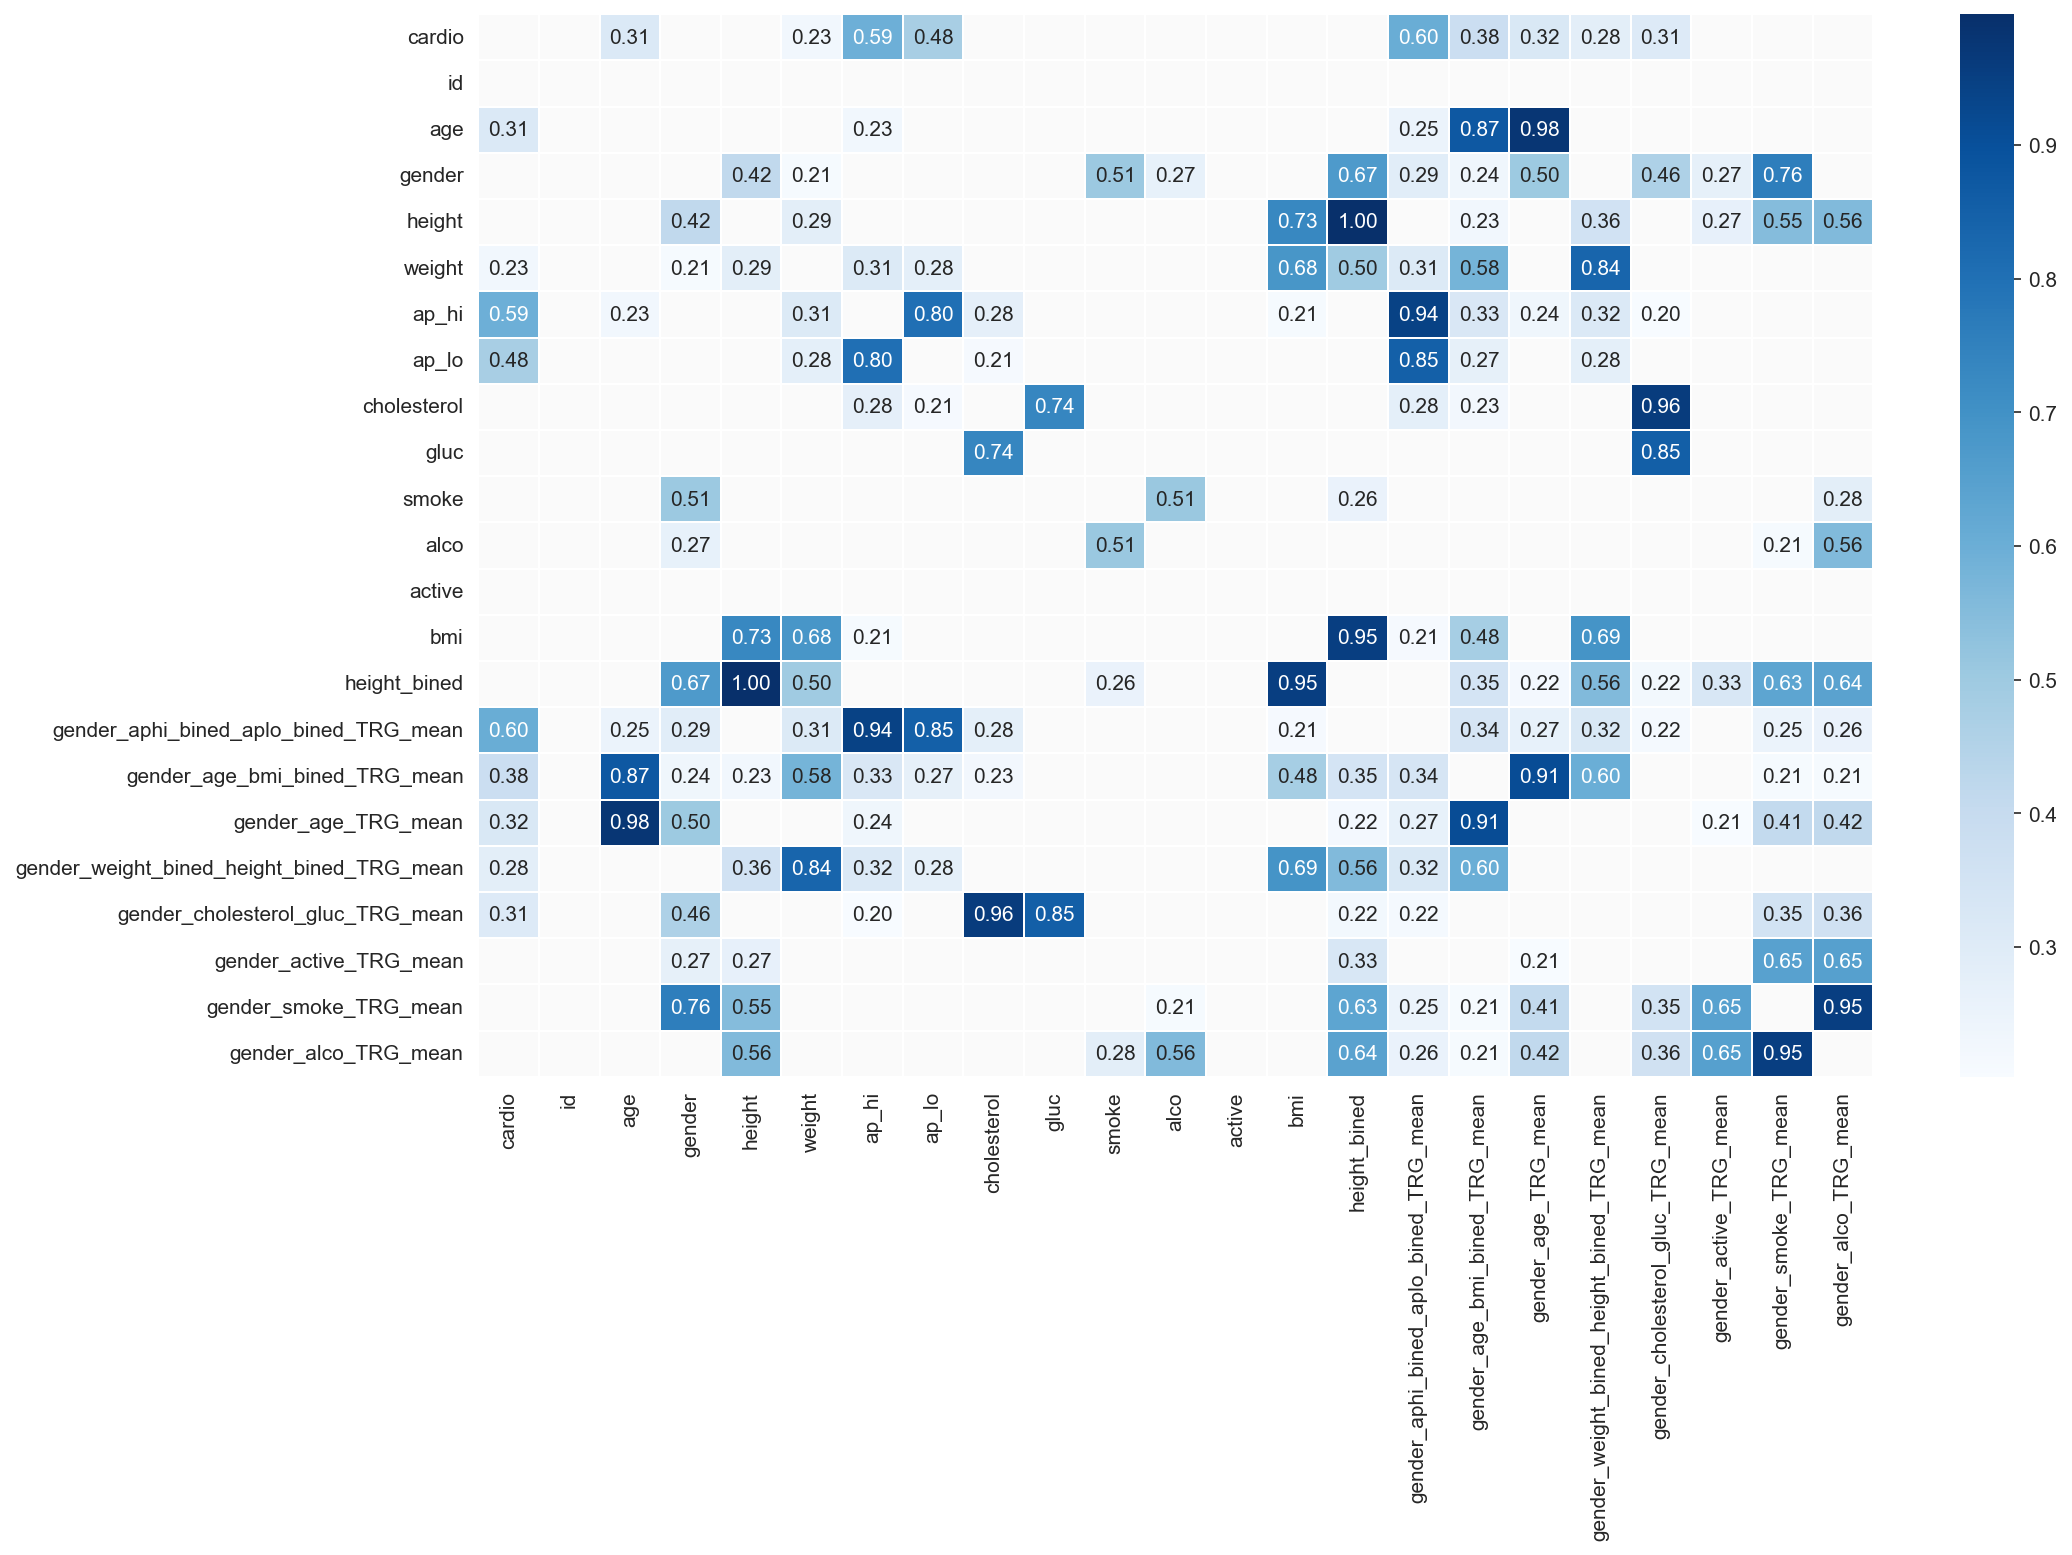

In [55]:
df = data_train.phik_matrix(interval_cols=interval_cols_list)

fig, ax = plt.subplots(figsize=(15, 0.4*df.shape[1]), dpi=PLOT_DPI)
sns.heatmap(df[(0.2 < df) & (df < 1.0)], annot=True, fmt='.2f', linewidths=0.2, annot_kws={'fontsize':10}, cmap='Blues')
plt.show()

### Correlation to target & Significance of the correlations

Корреляция признаков с целевой переменной и нормированная статистическая значимость корреляций, а также их произведение и гармоническое среднее.

In [57]:
# # по отношению к целевому признаку
# # объединенная таблица корреляций и их нормированной статистической значимости
# # сортировка по произведению корреляции и статистической значимости
# # дополнительно: гармоническое среднее корреляции и статистической значимости
# # вопрос: что более показательно – произведение или гармоническое среднее?

# # correlation to target
# df_1 = (data_train.phik_matrix(interval_cols=interval_cols_list)
#                   .cardio
#                   .to_frame()
#                   .drop('cardio', axis=0)  # correlation to self
#                   .rename(columns={'cardio': 'correlation'})
#        )

# # significance of the correlations
# df_2 = (data_train.significance_matrix(interval_cols=interval_cols_list, nsim=50)
#                   .cardio
#                   .to_frame()
#                   .drop('cardio', axis=0)  # correlation to self
#                   .assign(cardio = lambda x: x.cardio / x.cardio.max())
#                   .rename(columns={'cardio': 'significance'})
#        )

# # joined
# (
#     df_1.join(df_2, how='outer')
#         .assign(product = lambda x: x.correlation * x.significance)
#         .assign(harmonic_mean = lambda x: 2 * x.correlation * x.significance / (x.correlation + x.significance))
#         .sort_values('harmonic_mean', ascending=False)
# )

### Outlier significance

Поиск наиболее статистически различимых интервалов (признак и целевая переменная).

In [58]:
def plot_outlier_significance_matrix(df, feature_1, feature_2, n_bins=10):
    
    df_1 = df[[feature_1, feature_2]].outlier_significance_matrix(interval_cols=[feature_2], ndecimals=0, bins=n_bins, quantile=True)
    fig, ax = plt.subplots(figsize=(15,1), dpi=PLOT_DPI)
    sns.heatmap(df_1, annot=True, fmt='.1f', linewidths=0.2, annot_kws={'fontsize':10}, cmap=CMAP_SYMMETRIC, vmin=-75, vmax=75);
    ax.set_title(f'{feature_2}: quantile binning')

    df_2 = df[[feature_1, feature_2]].outlier_significance_matrix(interval_cols=[feature_2], ndecimals=0, bins=n_bins+1)
    fig, ax = plt.subplots(figsize=(15,1), dpi=PLOT_DPI)
    sns.heatmap(df_2, annot=True, fmt='.1f', linewidths=0.2, annot_kws={'fontsize':10}, cmap=CMAP_SYMMETRIC, vmin=-75, vmax=75)
    ax.set_title(f'{feature_2}: uniform binning')
    ax.set_xlabel(feature_2);

In [59]:
# features_to_explore = ['age','height','weight','ap_hi','ap_lo']

# for feature in features_to_explore:
#     plot_outlier_significance_matrix(df=data_train, feature_1='cardio', feature_2=feature)

Для примера: попарное сравнение признаков для обнаружения статистических отклонений.

In [60]:
# feature_1 = "ap_lo"
# feature_2 = "ap_hi"
# interval_cols_list = ["ap_hi", "ap_lo"]

# df = data_train[[feature_1, feature_2]].outlier_significance_matrix(interval_cols=interval_cols_list, ndecimals=0, bins={feature_1:3,feature_2:6})

# fig, ax = plt.subplots(figsize=(15,3), dpi=PLOT_DPI)
# sns.heatmap(df, annot=True, fmt='.1f', linewidths=0.2, annot_kws={'fontsize':10}, cmap=CMAP_SYMMETRIC, vmin=-75, vmax=75);

## Mutual info

In [62]:
# mutual_info(data_train.drop('cardio', axis=1), data_train.cardio, task='classification', max_neighbors=7)

## Data save

Сохранение обработанных данных для следующего этапа.

In [63]:
new_num_features_list

['gender_aphi_bined_aplo_bined_TRG_mean',
 'gender_age_bmi_bined_TRG_mean',
 'gender_age_TRG_mean',
 'gender_weight_bined_height_bined_TRG_mean',
 'gender_cholesterol_gluc_TRG_mean',
 'gender_active_TRG_mean',
 'gender_smoke_TRG_mean',
 'gender_alco_TRG_mean']

In [64]:
new_cat_features_list

[]

In [65]:
features_list = (
                 [                           # source features
#                 'age',
#                   'gender',
#                   'height',
#                   'weight',
#                   'ap_hi',
#                   'ap_lo',
#                    'cholesterol',
#                    'gluc',
#                   'smoke',
#                   'alco',
#                   'active',
                 ] +                         # new features
                 [
#                   'gender_aphi_bined_aplo_bined_TRG_mean',
#                   'gender_age_bined_weight_bined_TRG_mean',
#                   'gender_cholesterol_gluc_bmi_TRG_mean',
#                   'gender_smoke_alco_active_TRG_mean',
#                   'gender_height_TRG_mean',
                 ]
                )

In [66]:
data_train[['cardio'] + features_list].to_csv('C:\\Users\\Admin\\Desktop\\DS studies\\Data\\Heart diseases\\PROJECT\\FINAL\\FE_train.csv', index=False)
data_test[['id'] + features_list].to_csv('C:\\Users\\Admin\\Desktop\\DS studies\\Data\\Heart diseases\\PROJECT\\FINAL\\FE_test.csv', index=False)